# Standard linear regression

## Direct approach
We will use artificial data

Text(0, 0.5, '$y$')

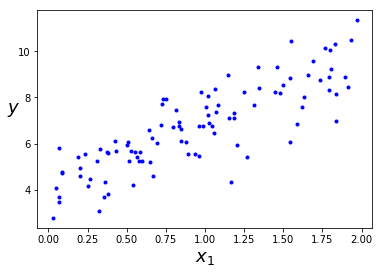

In [1]:
import matplotlib.pyplot as plt
import numpy as np
X = 2*np.random.rand(100,1);
y = 4+3*X+np.random.randn(100,1);

%matplotlib inline
plt.plot(X,y,'b.');
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)

In [2]:
import os
PROJECT_ROOT_DIR = os.path.dirname( os.path.realpath(os.curdir));
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    

### Compute the inverse
We will use `np.linalg.inv()`. First we must append a column of 1s for the intercept.

In [2]:
X_b = np.c_[np.ones((100,1)), X]

In [4]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
theta_best

array([[4.17345599],
       [2.97116864]])

### Scikit function

In [6]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression();
lin_reg.fit(X, y);
lin_reg.intercept_, lin_reg.coef_

(array([4.17345599]), array([[2.97116864]]))

The LinearRegression class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares"), which you could call directly. This function computes $\mathbf{X}^+ \mathbf{y}$, where $\mathbf{X}^{+}$ is the pseudoinverse of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly.

The pseudo-inverse does not rely on the Normal equation but on the SVD.


Note: the first releases of the book implied that the LinearRegression class was based on the Normal Equation. This was an error: as explained above, it is based on the pseudoinverse, which ultimately relies on the SVD matrix decomposition of $\mathbf{X}$ (see chapter 8 for details about the SVD decomposition). Its time complexity is $O(n^2)$ and it works even when $m &lt; n$ or when some features are linear combinations of other features (in these cases, $\mathbf{X}^T \mathbf{X}$ is not invertible so the Normal Equation fails), see issue #184 for more details. However, this does not change the rest of the description of the LinearRegression class, in particular, it is based on an analytical solution, it does not scale well with the number of features, it scales linearly with the number of instances, all the data must fit in memory, it does not require feature scaling and the order of the instances in the training set does not matter.

In [7]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b,y, rcond=1e-6);
theta_best_svd

array([[4.17345599],
       [2.97116864]])

In [8]:
theta_best_svd2 = np.linalg.pinv(X_b).dot(y)
theta_best_svd2

array([[4.17345599],
       [2.97116864]])

## Gradient Descent approach

Suppose you are lost in the mountains in a dense fog; you can only feel the slope of the ground below your feet. A good strategy to get to the bottom of the valley quickly is to go downhill in the direction of the steepest slope. This is exactly what Gradient Descent does: it measures the local gradient of the error function with regards to the parameter vector θ, and it goes in the direction of descending gradient. Once the gradient is zero, you have reached a minimum!

Concretely, you start by filling θ with random values (this is called random initializa‐ tion), and then you improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function (e.g., the MSE), until the algorithm converges to a minimum.

The mean squared error is

$$ \frac{1}{m} (y-\theta^TX)^T(y-\theta^TX)$$

Hence the gradient is

$$ -\frac{2}{m} (y-\theta^TX)$$

In [9]:
eta = 0.1; #learning rate
n_iter = 1000;
m = X_b.shape[0];

theta = np.random.randn(2,1);
for iter in range(n_iter):
    gradients = -2/m *X_b.T.dot( y-X_b.dot(theta)  );
    theta = theta -eta*gradients;
theta

array([[4.17345599],
       [2.97116864]])

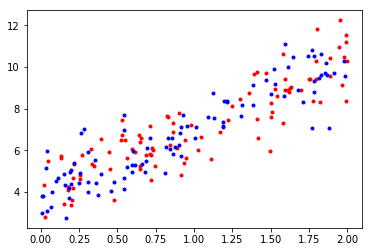

In [10]:
from matplotlib.pyplot import savefig
def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path_bgd.append(theta)
    plt.xlabel("$x_1$", fontsize=18)

    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

Saving figure gradient_descent_plot


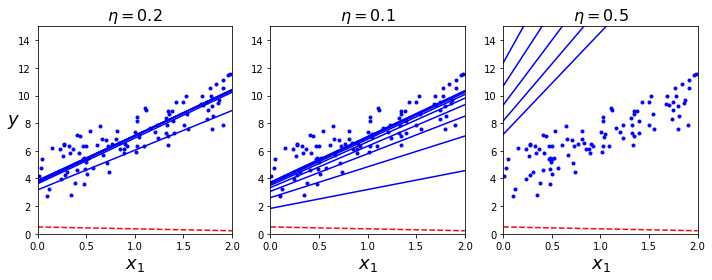

In [12]:

import numpy as np
theta_path_bgd=[];
np.random.seed(42);
theta = np.random.randn(2,1);  # random initialization
X_new = np.array([[0], [2]]);
X_new_b = np.c_[np.ones((2, 1)), X_new];


plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.2)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()


### Learning rate
To find a good value of eta we can use grid search. However, you may want to limit the number of iterations so that grid search can eliminate models that take too long to converge.

A simple solution is to set a very large number of iterations but to interrupt the algorithm when the gradient vector becomes tiny—that is, when its norm becomes smaller than a tiny number ε (called the tolerance)—because this happens when Gradient Descent has (almost) reached the minimum.

When the cost function is convex and its slope does not change abruptly (as is the case for the MSE cost function), it can be shown that Batch Gradient Descent with a fixed learning rate has a convergence rate of $O(\frac{1}{iterations}$. In other words, if you divide the tolerance $\epsilon$ by $10$ (to have a more precise solution), then the algorithm will have to run about 10 times more iterations.

# Stochastic gradient descent
The main problem with **Batch Gradient Descent** is the fact that it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large. At the opposite extreme, **Stochastic Gradient Descent** just picks a random instance in the training set at every step and computes the gradients based only on that single instance. Obviously this makes the algorithm much faster since it has very little data to manipulate at every iteration. It also makes it possible to train on huge training sets, since only one instance needs to be in memory at each iteration (SGD can be implemented as an out-of-core algorithm.)

On the other hand, due to its stochastic (i.e., random) nature, this algorithm is much less regular than Batch Gradient Descent: instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on aver‐ age. Over time it will end up very close to the minimum, but once it gets there it will continue to bounce around, never settling down. So once the algorithm stops, the final parameter values are good, but not optimal.

When the cost function is very irregular (as in Figure 4-6), this can actually help the algorithm jump out of local minima, so Stochastic Gradient Descent has a better chance of finding the global minimum than Batch Gradient Descent does. Therefore randomness is good to escape from local optima, but bad because it means that the algorithm can never settle at the minimum.

 One solution to this dilemma is to gradually reduce the learning rate. The steps start out large (which helps make quick progress and escape local minima), then get smaller and smaller, allowing the algorithm to settle at the global minimum. This process is called simulated annealing, because it resembles the process of annealing in metallurgy where molten metal is slowly cooled down.
 
The function that determines the learning rate at each iteration is called the **learning schedule**.

Saving figure sgd_plot


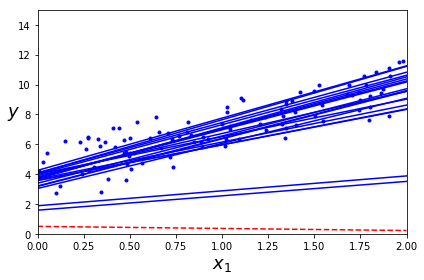

array([[4.17932368],
       [2.95382611]])

In [13]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

n_epochs = 50;
#learning schedul hyperparameters:
t0, t1 = 5, 50;

def learning_schedule(t):
    return t0/(t+t1);

m = X_b.shape[0];
theta = np.random.randn(2,1);
for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown        
        random_idx = np.random.randint(m);
        xi = X_b[random_idx:random_idx+1];
        yi = y[random_idx:random_idx+1];
        gradients = -2*xi.T.dot(yi-xi.dot(theta));
        eta = learning_schedule(epoch*m+1);
        theta = theta - eta*gradients;
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
save_fig("sgd_plot")                                 # not shown
plt.show()                                           # not shown
theta

While the Batch Gradient Descent code iterated 1,000 times through the whole train‐ ing set, this code goes through the training set only 50 times and reaches a fairly good solution.

Note that since instances are picked randomly, some instances may be picked several times per epoch while others may not be picked at all. If you want to be sure that the algorithm goes through every instance at each epoch, another approach is to shuffle the training set, then go through it instance by instance, then shuffle it again, and so on. However, this generally converges more slowly.

### Stochastic Gradient descent linear regression in scikit
The scikit-learn class to be used is `SGDRegressor`. The following code runs 50 epochs, starting with a learning rate of 0.1 (eta0=0.1), using the default learning schedule (different from the preceding one), and it does not use any regularization.

In [14]:
from sklearn.linear_model import SGDRegressor
# y's shape is (100,1) while it is expecting (100,). we use ravel() to flatten the array
sgd_regressor = SGDRegressor(n_iter=50, penalty=None, eta0=0.1, random_state=42);
sgd_regressor.fit(X_b, y.ravel());

/Users/fra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [15]:
sgd_regressor.coef_

array([2.1048274, 3.0030147])

# Mini-batch Gradient Descent
At each step, instead of computing the gradients based on the full train‐ ing set (as in Batch GD) or based on just one instance (as in Stochastic GD), Minibatch GD computes the gradients on small random sets of instances called mini- batches. The main advantage of Mini-batch GD over Stochastic GD is that you can get a performance boost from hardware optimization of matrix operations, especially when using GPUs. The algorithm’s progress in parameter space is less erratic than with SGD, especially with fairly large mini-batches. As a result, Mini-batch GD will end up walking around a bit closer to the minimum than SGD. But, on the other hand, it may be harder for it to escape from local minima 

In [16]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [17]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure gradient_descent_paths_plot


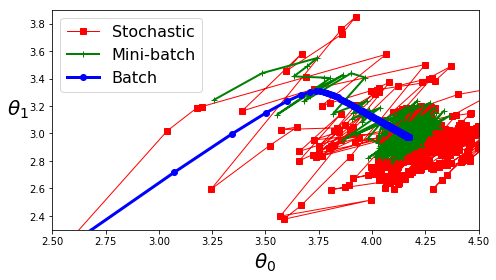

In [18]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

# Polynomial regression
### Let us generate data

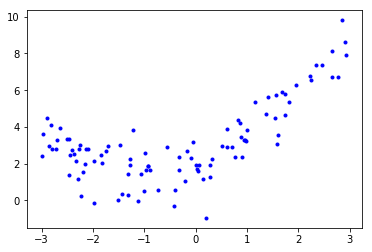

In [61]:
del X,y
m = 100;
X_poly = 6*np.random.rand(m, 1)-3;
y_poly = 0.5*X_poly**2 + X_poly + 2 + np.random.randn(m,1);
plt.plot(X_poly,y_poly,'b.');

### Polynomial features

In [62]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False);
X_poly_transf = poly_features.fit_transform(X_poly);
X_poly_transf[0]

array([-1.4436696,  2.0841819])

`X_poly_transf` now contains the original feature of `X` plus the square of this feature. Now we can fit linear regression

In [63]:
lin_reg = LinearRegression();
lin_reg.fit(X_poly_transf, y_poly);
lin_reg.intercept_, lin_reg.coef_

(array([1.96301211]), array([[0.94048827, 0.48463253]]))

In [64]:
lin_reg.coef_.shape

(1, 2)

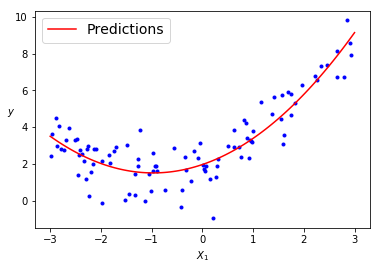

In [65]:
X_new      = np.linspace(-3, 3, 100).reshape(100, 1);
X_new_poly = poly_features.transform(X_new);
y_new      = lin_reg.predict(X_new_poly)
plt.plot(X_poly, y_poly,'b.');
plt.plot(X_new, y_new,'r', label="Predictions");
plt.legend(loc="upper left", fontsize=14);
plt.xlabel("$X_1$");
plt.ylabel("$y$",rotation=0);


Note that when there are multiple features, Polynomial Regression is capable of finding relationships between features (which is something a plain Linear Regression model cannot do). `PolynomialFeatures` also adds all combinations of features up to the given degree. For example, if there were two features $a$ and $b$, `PolynomialFeatures` with `degree=3` would not only add the features $a^2$, $a^3$, $b^2$, and $b^3$, but also the combinations $ab$, $a^2b$, and $ab^2$.
`PolynomialFeatures(degree=d)` transforms an array containing $n$ features into an array containing $\frac{(n + d)!}{d!n!}$ features.
  

Saving figure high_degree_polynomials_plot


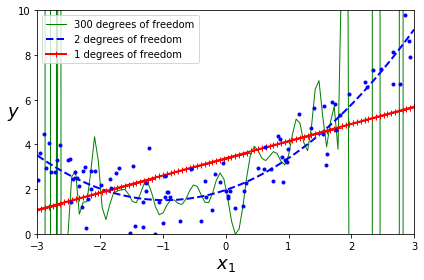

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression.fit(X_poly, y_poly)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree)+" degrees of freedom", linewidth=width)

plt.plot(X_poly, y_poly, "b.", linewidth=3);
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

# Model evaluation
If a model performs well on the training data but generalizes poorly according to the cross-validation metrics, then your model is overfitting. If it per‐ forms poorly on both, then it is underfitting. This is one way to tell when a model is too simple or too complex.

Another way is to look at the learning curves: these are plots of the model’s performance on the training set and the validation set as a function of the training set size. To generate the plots, simply train the model several times on different sized subsets of the training set. The following code defines a function that plots the learning curves of a model given some training data.

In [71]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2);
    train_errors, val_errors = [], [];
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m]);
        y_train_pred    = model.predict(X_train[:m]);
        y_val_pred    = model.predict(X_val);
        train_errors.append(mean_squared_error(y_train_pred,    y_train[:m]));
        val_errors  .append(mean_squared_error(y_val_pred   , y_val));
    plt.plot(np.sqrt(train_errors), "r-", linewidth=2, label="train");#math.sqrt appplies only to numbers not list
    plt.plot(np.sqrt(val_errors),   "b-", linewidth=2, label="validation");
    plt.legend();

#### Let's look at the learning curves of the plain Linera Regression:

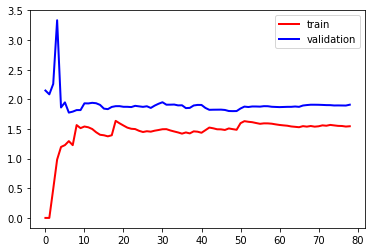

In [81]:
lin_reg = LinearRegression();
plot_learning_curves(lin_reg,X_poly,y_poly);

#### Comments on the graph
When there are just one or two instances, the model, which is a line, can fit them perfectly, hence the error of the training set is $0$. As new instances are added it becomes impossible to fit all of them, bacuase they are noisy. So the training error goes up until it reaches a plateau.  The error on the training data goes up until it reaches a plateau, at which point adding new instances to the training set doesn’t make the average error much better or worse.

When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite big. Then as the model is shown more training examples, it learns and thus the validation error slowly goes down. However, once again a straight line cannot do a good job modeling the data, so the error ends up at a plateau, very close to the other curve.

**These learning curves are typical of an underfitting model. Both curves have reached a plateau; they are close and fairly high.**

### Learning curve of a much higher polynomial

(-10, 10)

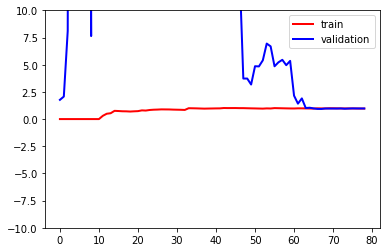

In [172]:
from sklearn.pipeline import Pipeline;
polynomial_regression = Pipeline((
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("sgd_reg", LinearRegression()),
));
plot_learning_curves(polynomial_regression, X, y);
plt.ylim([-10,10])

These learning curves look a bit like the previous ones, but there are two very important differences:
- The error on the training data is much lower than with the Linear Regression model.
- There is a gap between the curves. This means that the model performs signifi‐ cantly better on the training data than on the validation data, which is the hall‐ mark of an overfitting model. However, if you used a much larger training set, the two curves would continue to get closer.

One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.

## BIAS vs VARIANCE vs IRREDUCIBLE ERROR
An important theoretical result of statistics and Machine Learning is the fact that a model’s generalization error can be expressed as the sum of three very different errors:
**Bias**
This part of the generalization error is due to wrong assumptions, such as assum‐ ing that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.

**Variance**
This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance, and thus to overfit the training data.

**Irreducible error**
This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data.


# REGULARIZED MODELS
Regularization forces the learning algorithm to not only fit the data but also keep the model
weights as small as possible. The regularization term should be added to the cost fucntion only during training.

Once the model is trained, you want to evaluate the model’s performance using the unregularized performance measure.
The bias term is not regularized.

For **Gradient Descent**  just $\alpha \mathbf{\theta}$ must be added.

It is important to scale the data (e.g., using a StandardScaler) before performing Ridge Regression, as it is sensitive to the scale of the input features. This is true of most regularized models.

Regularization increase the model's bias but reduces its variance.

Saving figure ridge_regression_plot


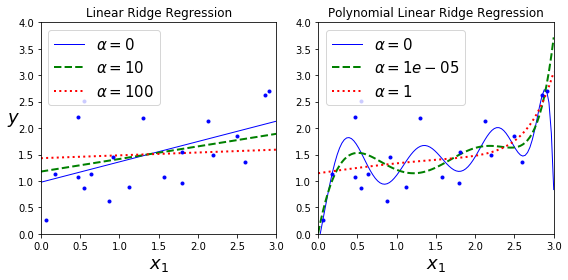

In [87]:
from sklearn.linear_model import Ridge

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, title=None, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])
    if title:
        plt.title(title);

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), title="Linear Ridge Regression", random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), title="Polynomial Linear Ridge Regression",random_state=42)

save_fig("ridge_regression_plot")
plt.show()

In [175]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky");
ridge_reg.fit(X,y);
ridge_reg.predict([[1.5]])

array([[4.82343657]])

## Stochastic Gradient regularized

In [185]:
# tol is the tolerance i.e., the stopping criterion the iterations will stop when 
# (loss > best_loss - tol) for n_iter_no_change consecutive epochs: i.e. the algorithm is not decreasing anymore the
# loss.
# max_iterThe maximum number of passes over the training data (aka epochs). 
#It only impacts the behavior in the fit method, and not the partial_fit method.
sgd_reg = SGDRegressor(penalty="l2", tol=0.001, max_iter=1000, random_state=42);
sgd_reg.fit(X,y.ravel());
sgd_reg.predict([[1.5]])

array([4.80459134])

## Lasso
Least Absolute Shrinkage and Selection.

An important characteristic of Lasso Regression is that it tends to completely elimi‐ nate the weights of the least important features. Lasso Regression automatically performs feature selection and outputs a sparse model.

On the Lasso cost function, the BGD path tends to bounce across the axis ($\theta_i=0$) toward the end. This is because the slope changes abruptly at θ2 = 0. You need to gradually reduce the learning rate in order to actually converge to the global minimum.


The Lasso cost function is not differentiable at $\theta_i = 0$ (for i = 1, 2, ⋯, n), but Gradient Descent still works fine if you use a subgradient vector $g$ instead when any $\theta_i = 0$. You can think of a subgradient vector at a nondifferentiable point as an intermediate vector between the gradient vectors around that point.

$g(\theta, J) = \nabla_\theta MSE(\theta) + \alpha \begin{pmatrix} sign(\theta_1)\\ sign(\theta_2)\\\vdots \\ sign(\theta_n) \end{pmatrix}$


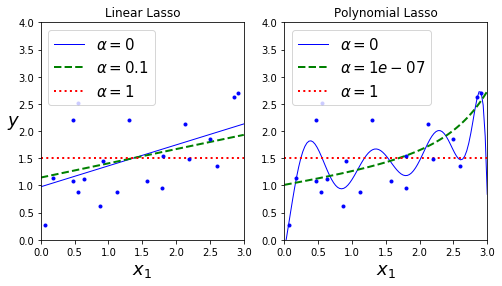

In [90]:
from sklearn.linear_model import Lasso
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1),title="Linear Lasso", random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, title="Polynomial Lasso",random_state=42)

In [91]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y);
lasso_reg.predict([[1.5]])

array([1.53788174])

In [92]:
sgd_reg_lasso = SGDRegressor(tol=0.001, max_iter=1000, penalty="l1", random_state=42);
sgd_reg_lasso.fit(X, y.ravel());
sgd_reg_lasso.predict([[1.5]])

array([1.47011206])

## Elastic Net
**Elastic Net** is a middle ground between Ridge Regression and Lasso Regression. The regularization term is a simple mix of both Ridge and Lasso’s regularization terms, and you can control the mix ratio $r$. When $r = 0$, Elastic Net is equivalent to Ridge Regression, and when $r = 1$, it is equivalent to Lasso Regression.

$$J(\theta) = MSE(\theta) + r \alpha \sum_{i=1}^n |\theta_i| + \frac{1-r}{2}\alpha  \sum_{i=1}^n \theta_i^2$$

It is almost always preferable to have at least a little bit of regularization, so generally you should avoid plain Linear Regression. 

**Ridge is a good default, but if you suspect that only a few features are actually useful, you should prefer Lasso or Elastic Net** since they tend to reduce the useless features’ weights down to zero as we have discussed. In general, **Elastic Net is preferred over Lasso** since Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

In [183]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5);
elastic_net.fit(X,y);
elastic_net.predict([[1.5]])

array([4.77593299])

# Early stopping

A very different way to regularize iterative learning algorithms such as Gradient Descent is to stop training as soon as the validation error reaches a minimum. This is called **early stopping**.

As the epochs go by, the algorithm learns and its prediction error (RMSE) on the training set naturally goes down, and so does its prediction error on the validation set. However, after a while the validation error stops decreasing and actually starts to go back up. This indicates that the model has started to overfit the training data. With early stopping you just stop training as soon as the validation error reaches the minimum.

With Stochastic and Mini-batch Gradient Descent, the curves are not so smooth, and it may be hard to know whether you have reached the minimum or not. One solution is to stop only after the validation error has been above the minimum for some time (when you are confident that the model will not do any better), then roll back the model parameters to the point where the validation error was at a minimum.

Saving figure early_stopping_plot


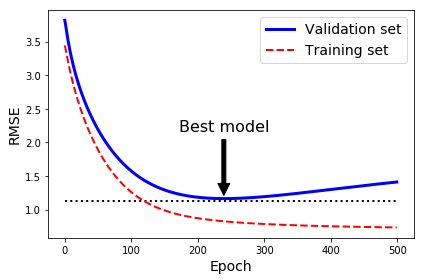

In [93]:
np.random.seed(42);
m = 100;
X = 6 * np.random.rand(m, 1) - 3;
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1);

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10);

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       tol=-np.infty,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

In [96]:
from sklearn.base import clone
sgd_reg = SGDRegressor(max_iter=1, warm_start=True, penalty=None, 
                       learning_rate="constant", eta0=0.0005,  tol=-np.infty,random_state=42);
minimum_val_error = float("inf");
best_epoch = None;
best_model = None;
X
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train);
    y_val_predict = sgd_reg.predict(X_val_poly_scaled);
    val_error = mean_squared_error(y_val_predict, y_val);
    if (val_error<minimum_val_error):
        minimum_val_error = val_error;
        best_epoch = epoch;
        best_model = clone(sgd_reg);

Note that with `warm_start=True`, when the `fit()` method is called, it just continues training where it left off instead of restarting from scratch. When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. See the Glossary.

In [97]:
best_epoch, best_model

(239,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
        eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
        learning_rate='constant', loss='squared_loss', max_iter=1,
        n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
        random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
        verbose=0, warm_start=True))

### Plotting paths of coefficients for Ridge and Lasso

In [98]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5;

# ignoring bias term
# 500 elements equally spaced btw -1 3
t1s = np.linspace(t1a, t1b, 500)

# 500 elements equally spaced btw -1.5 1.5
t2s = np.linspace(t2a, t2b, 500)

#creates a grid (if t1s=[1,2,3] and t2s=[1,2]), t1=[[1,2,3][1,2,3]] and t2= [[1,1,1],[2,2,2],[3,3,3]]
t1, t2 = np.meshgrid(t1s, t2s);
T = np.c_[t1.ravel(), t2.ravel()];

Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])

yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

#cost function of OLS
J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

#biggest norm1 of the rows
N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)


t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

In [109]:
t_init

array([[ 0.25],
       [-1.  ]])

In [107]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5;

# ignoring bias term
# 500 elements equally spaced btw -1 3
t1s = np.linspace(t1a, t1b, 5)

# 500 elements equally spaced btw -1.5 1.5
#t2s = np.linspace(t2a, t2b, 5)

#creates a grid (if t1s=[1,2,3] and t2s=[1,2]), t1=[[1,2,3][1,2,3]] and t2= [[1,1,1],[2,2,2],[3,3,3]]
#grid of parameter space
t1, t2 = np.meshgrid(t1s, t2s);

#T will contain in the first column the grid-values t1 of the first parameter and
# in the second column the grid-values of the second
T = np.c_[t1.ravel(), t2.ravel()];

Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])

yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

#cost function of OLS
J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

#return the sum of the abs of each row, ord=np.inft return the max of each row.
# The 2 columns of T are the samples of the 2 parameters. Each row hence is a possible pair 
# for the parameter. For each of such rows we will calculate the penalization term
N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape);

#return the sum of the squared values of each row
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)
np.linalg.norm(T, ord=1, axis=1)

3500.0

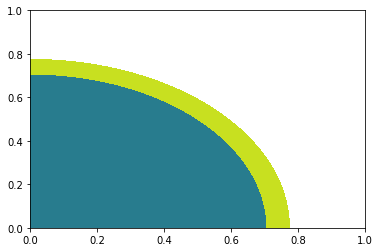

<Figure size 432x288 with 0 Axes>

In [124]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
[X,Y] = np.meshgrid(x,y)

Z = X**2 + Y**2

#plt.subplot(1,2,1)
#plt.imshow(Z, origin = 'lower')
#plt.subplot(1,2,2)
#x,y are optionally and levels too.
# x,y work as axis, Z is the function.
#levels can be an integer, in which case it creates n regions,
# otherswise if a list/array, the values specify the contour of regions
plt.contourf(x,y,Z,levels=[0,0.5,0.6])
plt.show()
plt.savefig('test.png')

In [125]:
levelsJ

array([7.09501836e-06, 4.39902426e-01, 9.03570248e-01, 1.39229525e+00,
       1.90743157e+00, 2.45040649e+00, 3.02272445e+00, 3.62597118e+00,
       4.26181812e+00, 4.93202701e+00, 5.63845483e+00, 6.38305888e+00,
       7.16790226e+00, 7.99515955e+00, 8.86712286e+00, 9.78620814e+00,
       1.07549619e+01, 1.17760684e+01, 1.28523567e+01, 1.39868090e+01])

a
a


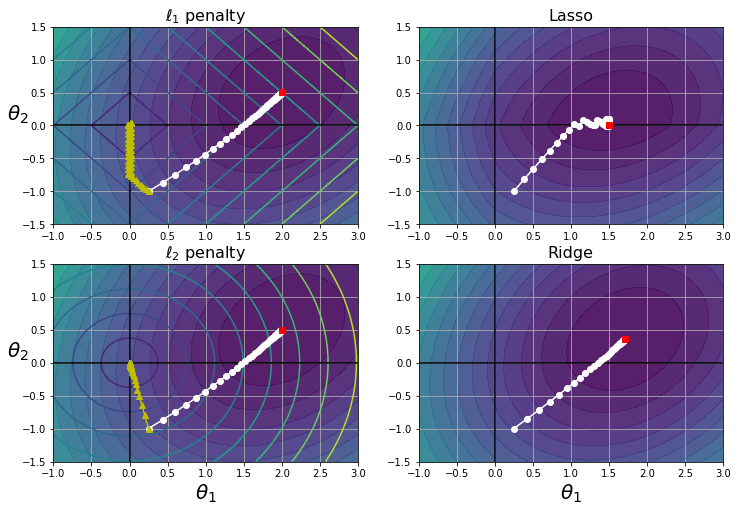

In [104]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.1, n_iterations = 50):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta

        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

plt.figure(figsize=(12, 8));

#2 iterations: the first for lasso (l1=0.5, l2=0) and the second for ridge l1=0, l2=0.2
# N1 and N2 are l1 and l2 penaliaztion terms
for i, N, l1, l2, title in ((0, N1, 0.5, 0, "Lasso"), (1, N2, 0,  0.1, "Ridge")):
    JR = J + l1 * N1 + l2 * N2**2
    
    # get the index of the minimum
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    #retrieve the two parametrs' values
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    # create the levels for the region (ellipses)
    levelsJ  = (np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J)  - np.min(J))  + np.min(J)
    levelsJR = (np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN  = np.linspace(0, np.max(N), 10)
    # t_init = 0.25, -1 starting point
    path_J  = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N  = bgd_path(t_init, Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    plt.subplot(221 + i * 2)
    plt.grid(True)
    #Add a horizontal line across the axis.
    plt.axhline(y=0, color='k');
    #Add a vertical line across the axis.    
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, J, levels=levelsJ, alpha=0.9)
    #contour plots without filling
    plt.contour(t1, t2, N, levels=levelsN)
    plt.plot(path_J[:, 0], path_J[:, 1], "w-o")
    plt.plot(path_N[:, 0], path_N[:, 1], "y-^")
    plt.plot(t1_min, t2_min, "rs")
    plt.title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)
    plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0)

    plt.subplot(222 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    plt.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    plt.plot(t1r_min, t2r_min, "rs")
    plt.title(title, fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)

#save_fig("lasso_vs_ridge_plot")
plt.show()

# Logistic regression

In [4]:
from sklearn import datasets;
iris = datasets.load_iris();
list(iris.keys())
print(iris['target_names']);
print(iris['feature_names']);

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [131]:
X_all = iris['data'];
y_all = iris['target'];
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [132]:
iris['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [143]:
iris['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [144]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Let’s try to build a classifier to detect the Iris-Virginica type based only on the petal
width feature

In [140]:
X = X_all[:,3].reshape(-1,1);
y = y_all==2;

In [146]:
X.shape

(150, 1)

In [145]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, solver="liblinear");
log_reg.fit(X,y);

Let’s look at the model’s estimated probabilities for flowers with petal widths varying
from 0 to 3 cm 

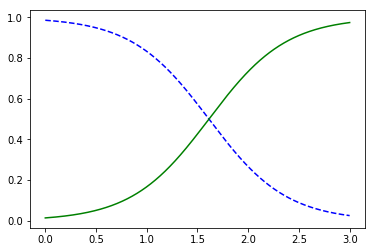

In [154]:
X_new   = np.linspace(0,3,1000).reshape(-1,1);
#predict_proba will return the probability for each class (2 classes in this case)
y_proba = log_reg.predict_proba(X_new);
plt.plot(X_new, y_proba[:,0],'b--',label="Not Iris-Virginica");
plt.plot(X_new, y_proba[:,1],'g-',label="Iris-Virginica");


In [208]:
#example
x = np.array([1,3]);
x[np.array([False,True])]


array([1.61561562])

In [209]:
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

[0, 3, -0.02, 1.02]

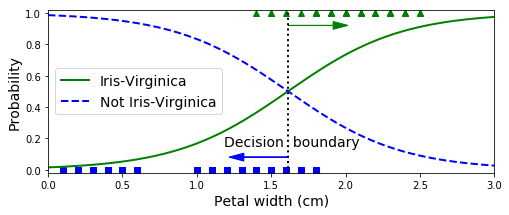

In [218]:
plt.figure(figsize=(8, 3));
plt.plot(X[y==0], y[y==0], "bs");
plt.plot(X[y==1], y[y==1], "g^");
plt.plot([decision_boundary, decision_boundary], [-0.5, 1.5], "k:", linewidth=2);
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica");
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica");
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center");
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14);
plt.ylabel("Probability", fontsize=14);
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])

The petal width of Iris-Virginica flowers (represented by triangles) ranges from $1.4cm$ to $2.5cm$, while the other iris flowers (represented by squares) generally have a smaller petal width, ranging from $0.1cm$ to $1.8cm$. Notice that there is a bit of overlap. Above about $2cm$ the classifier is highly confident that the flower is an Iris- Virginica (it outputs a high probability to that class), while below $1cm$ it is highly confident that it is not an Iris-Virginica (high probability for the “Not Iris-Virginica” class). In between these extremes, the classifier is unsure. However, if you ask it to predict the class (using the `predict()` method rather than the `predict_proba()` method), it will return whichever class is the most likely. Therefore, there is a decision boundary at around $1.6cm$ where both probabilities are equal to $50%$: if the petal width is higher than $1.6 cm$, the classifier will predict that the flower is an Iris-Virginica, or else it will predict that it is not (even if it is not very confident):

In [235]:
log_reg.predict([[1.599999],[1.613]])

array([False,  True])

#### Use petal width and length

In [20]:

X = iris['data'][:,2:4];
y = (iris["target"] == 2).astype(np.int);
X.shape

(150, 2)

In [22]:
from sklearn.linear_model import LogisticRegression
#Inverse of regularization strength; must be a positive float. 
#Like in support vector machines, smaller values specify stronger regularization.
log_reg = LogisticRegression(solver="liblinear", C=10**10, random_state=42);
log_reg.fit(X, y);




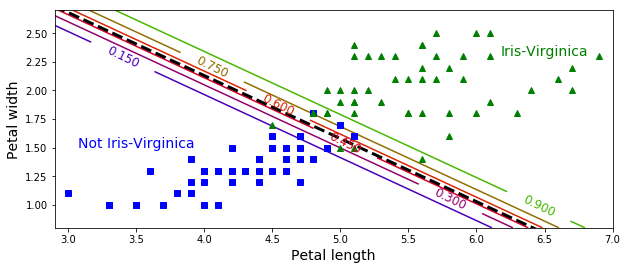

In [24]:
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    );
X_new = np.c_[x0.ravel(), x1.ravel()];
y_proba = log_reg.predict_proba(X_new);

plt.figure(figsize=(10, 4));
plt.plot(X[y==0, 0], X[y==0, 1], "bs");
plt.plot(X[y==1, 0], X[y==1, 1], "g^");
zz = y_proba[:, 1].reshape(x0.shape);
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg);

left_right = np.array([2.9, 7]);
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1];

plt.clabel(contour, inline=1, fontsize=12);
plt.plot(left_right, boundary, "k--", linewidth=3);
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center");
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center");
plt.xlabel("Petal length", fontsize=14);
plt.ylabel("Petal width", fontsize=14);
plt.axis([2.9, 7, 0.8, 2.7]);
#save_fig("logistic_regression_contour_plot");
plt.show();

### Logistic Regression regularization
Just like the other linear models, Logistic Regression models can be regularized using l1 or l2 penalties. Scitkit-Learn actually adds an l2 penalty by default.
The hyperparameter controlling the regularization strength of a Scikit-Learn LogisticRegression model is not alpha (as in other linear models), but its inverse: C. The higher the value of C, the less the model is regularized.

# Multinomial logistic regression aka Softmax
Let’s use Softmax Regression to classify the iris flowers into all three classes. Scikit-Learn’s LogisticRegression uses one-versus-all by default when you train it on more than two classes, but you can set the **`multi_class`** hyperparameter to **`multinomial`** to switch it to Softmax Regression instead. You must also specify a solver that supports Softmax Regression, such as the **`lbfgs`** solver (see Scikit-Learn’s documentation for more details). It also applies l2 regularization by default, which you can control using the hyperparameter C.

In [25]:
from sklearn.linear_model import LogisticRegression
X = iris["data"][:,2:4];
y = iris['target'];

In [28]:
soft_max = LogisticRegression(multi_class="multinomial", solver='lbfgs', C=10);
soft_max.fit(X,y);

So the next time you find an iris with 5 cm long and 2 cm wide petals, you can ask your model to tell you what type of iris it is, and it will answer Iris-Virginica (class 2) with 94.2% probability (or Iris-Versicolor with 5.8% probability):

In [29]:
soft_max.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

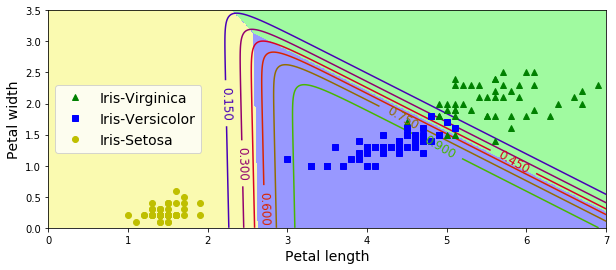

In [47]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    );
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba   = soft_max.predict_proba(X_new);
y_predict = soft_max.predict(X_new);

zz1 = y_proba[:, 1].reshape(x0.shape);
zz  = y_predict.reshape(x0.shape);

plt.figure(figsize=(10, 4));
#plot the training points
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0']);

#plot areas filled with colors
plt.contourf(x0, x1, zz, cmap=custom_cmap);

#plot decision boundaries
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg);
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
#save_fig("softmax_regression_contour_plot")
plt.show()

# Exercises
## 1) What Linear Regression training algorithm can you use if you have a training set with millions of features?
If you have a training set with millions of features you can use Stochastic Gradient Descent or Mini-batch Gradient Descent, and perhaps Batch Gradient Descent if the training set fits in memory. But you cannot use the Normal Equation because the computational complexity grows quickly (more than quadratically) with the number of features.

## 2) Suppose the features in your training set have very different scales. What algorithms might suffer from this, and how? What can you do about it?

If the features in your training set have very different scales, the cost function will have the shape of an elongated bowl, so the Gradient Descent algorithms will take a long time to converge. To solve this you should scale the data before training the model. Note that the Normal Equation will work just fine without scaling.



## 3) Can Gradient Descent get stuck in a local minimum when training a Logistic Regression model?

Gradient Descent cannot get stuck in a local minimum when training a Logistic Regression model because the cost function is convex.

## 4)  Do all Gradient Descent algorithms lead to the same model provided you let them run long enough?
If the optimization problem is convex (such as Linear Regression or Logistic Regression), and assuming the learning rate is not too high, then all Gradient Descent algorithms will approach the global optimum and end up producing fairly similar models. However, unless you gradually reduce the learning rate, Stochastic GD and Mini-batch GD will never truly converge; instead, they will keep jumping back and forth around the global optimum. This means that even if you let them run for a very long time, these Gradient Descent algorithms will produce slightly different models.

## 5) Suppose you use Batch Gradient Descent and you plot the validation error at every epoch. If you notice that the validation error consistently goes up, what is likely going on? How can you fix this?

If the validation error consistently goes up after every epoch, then one possibility is that the learning rate is too high and the algorithm is diverging. If the training error also goes up, then this is clearly the problem and you should reduce the learning rate. However, if the training error is not going up, then your model is overfitting the training set and you should stop training.

## 6) Is it a good idea to stop Mini-batch Gradient Descent immediately when the vali‐ dation error goes up?

Due to their random nature, neither Stochastic Gradient Descent nor Mini-batch Gradient Descent is guaranteed to make progress at every single training itera‐ tion. So if you immediately stop training when the validation error goes up, you may stop much too early, before the optimum is reached. A better option is to save the model at regular intervals, and when it has not improved for a long time (meaning it will probably never beat the record), you can revert to the best saved model.

## 7) Which Gradient Descent algorithm (among those we discussed) will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?

Stochastic Gradient Descent has the fastest training iteration since it considers only one training instance at a time, so it is generally the first to reach the vicinity of the global optimum (or Mini-batch GD with a very small mini-batch size). However, only Batch Gradient Descent will actually converge, given enough training time. As mentioned, Stochastic GD and Mini-batch GD will bounce around the optimum, unless you gradually reduce the learning rate.

## 8) Suppose you are using Polynomial Regression. You plot the learning curves and you notice that there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?

If the validation error is much higher than the training error, this is likely because your model is overfitting the training set. One way to try to fix this is to reduce the polynomial degree: a model with fewer degrees of freedom is less likely to overfit. Another thing you can try is to regularize the model—for example, by adding an l2 penalty (Ridge) or an l1 penalty (Lasso) to the cost function. This will also reduce the degrees of freedom of the model. Lastly, you can try to increase the size of the training set.

## 9) Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regulari‐ zation hyperparameter α or reduce it?

If both the training error and the validation error are almost equal and fairly high, the model is likely underfitting the training set, which means it has a high bias. You should try reducing the regularization hyperparameter $\alpha$.

## 10) Why would you want to use:
## - Ridge Regression instead of plain Linear Regression (i.e., without any regularization)?
## - Lasso instead of Ridge Regression?
## - Elastic Net instead of Lasso?

- A model with some regularization typically performs better than a model without any regularization, so you should generally prefer Ridge Regression over plain Linear Regression.
- Lasso Regression uses an l1 penalty, which tends to push the weights down to exactly zero. This leads to sparse models, where all weights are zero except for the most important weights. This is a way to perform feature selection automatically, which is good if you suspect that only a few features actually matter. When you are not sure, you should prefer Ridge Regression.
- Elastic Net is generally preferred over Lasso since Lasso may behave erratically in some cases (when several features are strongly correlated or when there are more features than training instances). However, it does add an extra hyperparameter to tune. If you just want Lasso without the erratic behavior, you can just use Elastic Net with an `l1_ratio` close to $1$.

## 11) Suppose you want to classify pictures as outdoor/indoor and daytime/nighttime. Should you implement two Logistic Regression classifiers or one Softmax Regression classifier?

If you want to classify pictures as outdoor/indoor and daytime/nighttime, since these are not exclusive classes (i.e., all four combinations are possible) you should train two Logistic Regression classifiers.

## 12) Implement Batch Gradient Descent with early stopping for Softmax Regression (without using Scikit-Learn)

## gradient formula

$$J(\theta) = -\frac{1}{m}\sum_{i=1}^m y_i \log \hat{p}_i + (1-y_i) \log (1 - \hat{p}_i )$$

$$\frac{\partial J(\theta)}{\partial \theta}= -\frac{1}{m}\sum_{i=1}^m y_i (1+e^{-x^T\theta})\frac{-(-x^T)e^{-x^T\theta} }{1+e^{-x_i^T\theta}} +(1-y_i)\frac{1+e^{-x_i^T\theta}}{e^{-x^T\theta}}\frac{-x_i^T e^{-x_i^T\theta} (1+e^{-x_i^T\theta})- (-x_i^T)e^{-x_i^T\theta}e^{-x_i^T\theta}}{(1+e^{-x_i^T\theta})^2}= -\frac{1}{m}\sum_{i=1}^m y_i \frac{x^Te^{-x^T\theta}}{1+e^{-x_i^T\theta}} + (1-y_i) \frac{-x_i^T }{1+e^{-x_i^T\theta}} = -\frac{1}{m}\sum_{i=1}\frac{y_i x_i^T e^{-x_i^T\theta} -x^T+y_ix^T}{1+e^{-x_i^T\theta}} =  -\frac{1}{m}\sum_{i=1} y_ix^T - x^T\frac{1}{e^{-x_i^T\theta}} =  -\frac{1}{m}\sum_{i=1} x_i^T(y_i - \hat{y}_i) = $$



In [ ]:
def to_one_hot(y):
    n_classes = y.max() + 1;
    m = len(y);
    Y_one_hot = np.zeros((m, n_classes));
    Y_one_hot[np.arange(m), y] = 1;
    return Y_one_hot

In [2]:
from sklearn import datasets;
import numpy as np;
iris = datasets.load_iris();
X = iris["data"];
y = iris["target"];
X_b = np.c_[np.ones((X.shape[0],1)), X];#nX(#features+1) matrix
y_new = np.concatenate(((y==0).reshape(-1,1), (y==1).reshape(-1,1), (y==2).reshape(-1,1)), axis=1);
#alternatively use y as index
numClasses = y.max()+1;
y_new2 = np.zeros([len(y), numClasses]);
y_new2[np.arange(len(y)), y] = 1;

test_ratio = 0.2;
validation_ratio = 0.2;
total_size = len(X_b);

test_size       = int(total_size * test_ratio);
validation_size = int(total_size * validation_ratio);
train_size      = total_size - test_size - validation_size;

rnd_indices = np.random.permutation(total_size);

X_train = X_b[rnd_indices[:train_size]];
y_train = y_new[rnd_indices[:train_size]].astype(float);
X_valid = X_b[rnd_indices[train_size:-test_size]];
y_valid = y_new[rnd_indices[train_size:-test_size]].astype(float);
X_test  = X_b[rnd_indices[-test_size:]];
y_test  = y_new[rnd_indices[-test_size:]].astype(float);


def soft_max(X, theta):
    logits = X.dot(theta);
    exps = np.exp(logits);
    #keepdims keep the dimension of the other axis(in this case keeps the dim of x=00)
    exp_sums = np.sum(exps, axis=1,keepdims=True)
    return exps/exp_sums;

theta  = np.random.randn(X_b.shape[1], y_new.shape[1]);

eta = 0.1; #learning rate
n_iter = 5001;
m = X_b.shape[0];
epsilon = 1e-7;

for itera in range(n_iter):       #nX(#features+1)
    y_pred = soft_max(X_train, theta);
    #each row of y_train and y_pred has 3 probs, the prob of the classes
    loss = -np.mean(np.sum(y_train          * np.log(y_pred       + epsilon), axis=1));#
    error = y_train - y_pred;
    if itera % 500 == 0:
        print(itera, loss);
    gradients = -1/m *X_train.T.dot( error  );
    theta = theta -eta*gradients;
len(y_train),theta

0 6.523196846636752
500 0.20263884737915128
1000 0.1439889175907722
1500 0.11711253498970954
2000 0.10120578600468096
2500 0.09048104468359279
3000 0.08265715411821062
3500 0.07663997794848244
4000 0.07183345074340496
4500 0.06788248701977101
5000 0.0645611123347447


(90, array([[-0.05121462,  1.37971828, -2.74394482],
        [ 2.04521371,  1.67990629, -1.69026815],
        [ 3.2901825 ,  0.59138433, -1.81607553],
        [-2.64255533,  0.22626478,  5.10151251],
        [-2.44107268, -1.29897249,  3.85621694]]))

In [3]:
y_prob_val = soft_max(X_valid, theta);
y_prob_val_res = np.zeros(y_prob_val.shape);
y_prob_val_res[np.arange(len(y_prob_val)), np.argmax(y_prob_val,axis=1)]=1;
accuracy = np.mean(np.floor(np.sum(y_prob_val_res.astype(int)==y_valid.astype(int), axis=1)/3));
accuracy

0.9666666666666667

### Regularization
let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of Theta since this corresponds to the bias term)


In [36]:
%reset
from sklearn import datasets;
import numpy as np;
np.random.seed(2042);
iris = datasets.load_iris();
X = iris["data"][:,2:4];
y = iris["target"];
X_b = np.c_[np.ones((X.shape[0],1)), X];#nX(#features+1) matrix
y_new = np.concatenate(((y==0).reshape(-1,1), (y==1).reshape(-1,1), (y==2).reshape(-1,1)), axis=1);
#alternatively use y as index
numClasses = y.max()+1;
y_new2 = np.zeros([len(y), numClasses]);
y_new2[np.arange(len(y)), y] = 1;

test_ratio = 0.2;
validation_ratio = 0.2;
total_size = len(X_b);

test_size       = int(total_size * test_ratio);
validation_size = int(total_size * validation_ratio);
train_size      = total_size - test_size - validation_size;

rnd_indices = np.random.permutation(total_size);

X_train = X_b[rnd_indices[:train_size]];
y_train = y_new[rnd_indices[:train_size]].astype(float);
X_valid = X_b[rnd_indices[train_size:-test_size]];
y_valid = y_new[rnd_indices[train_size:-test_size]].astype(float);
X_test  = X_b[rnd_indices[-test_size:]];
y_test  = y_new[rnd_indices[-test_size:]].astype(float);

epsilon= 1e-7;
def soft_max(X, theta):
    logits = X.dot(theta);
    exps = np.exp(logits);
    #keepdims keep the dimension of the other axis(in this case keeps the dim of x=00)
    exp_sums = np.sum(exps, axis=1,keepdims=True)
    return exps/exp_sums;

best_loss = np.infty;
eta = 0.1;
iterations = 5001;
alpha = 0.05;
eps = 1e-7;
np.random.seed(52);
theta = np.random.randn(X_b.shape[1], y_new.shape[1]);
m = len(X_train);
for ii in range(iterations):
    y_pred = soft_max(X_train, theta);
    entropy_loss = -np.mean(np.sum(y_train * np.log(y_pred +  eps), axis=1));
    #the first row of theta are the intercepts
    l2_loss = np.sum(np.square(theta[1:,:]));
    loss = entropy_loss+alpha*l2_loss;
    error = y_train-y_pred;
    #if ii%1000==0:
    #    print(iter, loss);
    gradients = - 1/m * X_train.T.dot(error) + np.r_[np.zeros((1, theta.shape[1])),2*alpha * theta[1:,:]];
    theta = theta - eta * gradients;
    print(theta)
    break;
    
    y_pred = soft_max(X_valid, theta);
    xentropy_loss = -np.mean(np.sum(y_valid * np.log(y_pred + epsilon), axis=1));
    l2_loss = np.sum(np.square(theta[1:]));
    loss = xentropy_loss + alpha * l2_loss;
    if loss < best_loss:
        best_loss = loss
    else:
        print(ii - 1, best_loss)
        print(ii, loss, "early stopping!")
        break    
y_prob_val = soft_max(X_valid, theta);
y_prob_val_res = np.zeros(y_prob_val.shape);
y_prob_val_res[np.arange(len(y_prob_val)), np.argmax(y_prob_val,axis=1)]=1;
accuracy = np.mean(np.floor(np.sum(y_prob_val_res.astype(int)==y_valid.astype(int), axis=1)/3));
accuracy

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


[[ 0.54212534 -1.25192542  0.20094556]
 [-0.77459227  0.0931792   0.29311577]
 [ 1.26697413  0.67567249 -0.47399373]]


0.26666666666666666

In [34]:
%reset
import numpy as np;
from sklearn import datasets;
import numpy as np;
np.random.seed(2042);
iris = datasets.load_iris();
X = iris["data"][:,2:4];
y = iris["target"];
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

X_with_bias = np.c_[np.ones([len(X), 1]), X]

test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size
rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty
np.random.seed(52);
Theta = np.random.randn(n_inputs, n_outputs)
for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))

    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients;
    print(Theta);
    break

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break
        
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


[[ 0.54212534 -1.25192542  0.20094556]
 [-0.77459227  0.0931792   0.29311577]
 [ 1.26697413  0.67567249 -0.47399373]]


0.26666666666666666

# FINAL PLOT

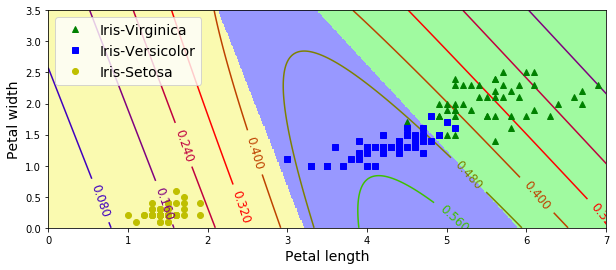

In [67]:
import matplotlib.pyplot as plt
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

Theta = theta;
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    );
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]
X_new_with_bias.shape, Theta.shape
logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)
%matplotlib inline
plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg);

plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

# BOok

In [57]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]
X_with_bias = np.c_[np.ones([len(X), 1]), X]
np.random.seed(2042)
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot


Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients
    logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693313
2000 0.5444496861981873
2500 0.5038530181431525
3000 0.4729228972192248
3500 0.4482424418895776
4000 0.4278651093928793
4500 0.41060071429187134
5000 0.3956780375390374


0.9666666666666667